# SMC2017: Exercise set I

## Setup

In [1]:
import numpy as np
from scipy import stats
import pandas as pd
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style()

## I.1 Importance sampling

$q(x) = N(x; 0, 1)$ and $\pi(x) = U(x; [0, 4])$

a) $q(x) > 0$ for all $x$. This is important since $\pi(x) > 0$ for $x \in [0, 4]$

b) Implement an importance sampler

In [3]:
stats.norm.pdf([0, 0.5, -0.5], loc=1, scale=0.5)

array([ 0.10798193,  0.48394145,  0.0088637 ])

In [5]:
stats.norm.pdf((np.array([0, 0.5, -0.5]) - 1) / 0.5) / 0.5

array([ 0.10798193,  0.48394145,  0.0088637 ])

In [6]:
stats.norm.pdf([0, 0.5, -0.5], loc=1, scale=0.5) == \
    stats.norm.pdf((np.array([0, 0.5, -0.5]) - 1) / 0.5) / 0.5

array([ True,  True,  True], dtype=bool)

In [19]:
class TooLittleSampleCoverage(Exception):
    """Thrown if there were too few samples to hit the target distribution."""
    pass

def target(x, val=0.25):
    # Create a new array that will be populated with zeros 
    # except when the component of x is between 0.0 and 4.0
    y = np.zeros_like(x)
    y[np.logical_and(x >= 0.0, x <= 4.0)] = val
    return y
    
def imp_sample_exact(N, loc=0.0, scale=1.0):
    # Sample from the proposal
    samples = stats.norm.rvs(loc, scale, N)
    # Calculate the exact weights
    weights = target(samples) / \
              stats.norm.pdf(samples, loc=loc, scale=scale)
    
    return samples, weights

def imp_sample_prop(N, loc=0.0, scale=1.0):
    # Sample from the proposal
    samples = stats.norm.rvs(loc, scale, N)
    # Calculate the weights
    weights = target(samples, val=1) / \
              stats.norm.pdf(samples, loc=loc, scale=scale)
    # Normalize the weights
    if np.sum(weights) == 0.0:
        raise TooLittleSampleCoverage
    weights_normalized = weights / np.sum(weights)
    
    return samples, weights, weights_normalized

Plot the resulting distribution as a weighted histogram

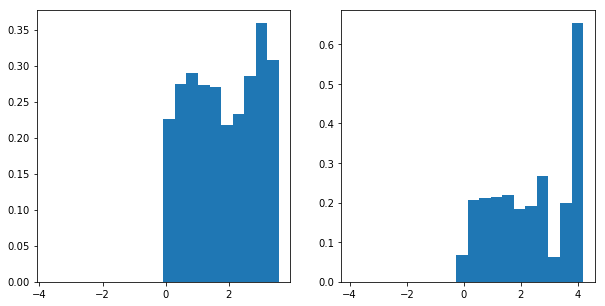

In [71]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Self-normalized
samples, weights, weights_normalized = imp_sample_prop(10000)
axs[0].hist(samples, bins=20, weights=weights_normalized, normed=True);

# Exact
samples, weights = imp_sample_exact(10000)
axs[1].hist(samples, bins=20, weights=weights, normed=True);

Problem: Often too little or too much probability on the ends of the uniform probability, probably caused by tail behaviour of the normal distribution.

c) Check for bias

Calculate mean value of $\pi(x)$ through importance sampling. Theoretical value: 2

Average: 1.9868088002610522
Bias: -0.013191199738947702


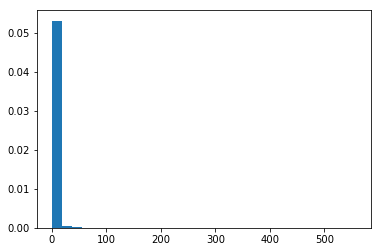

In [75]:
M = 8000
exp_vals = np.zeros((M,))

for i in range(M):
    samples, weights = imp_sample_exact(10)
    exp_vals[i] = np.mean(samples * weights)
    
print("Average: {}".format(exp_vals.mean()))
biases = exp_vals - 2
print("Bias: {}".format(biases.mean()))

fig, ax = plt.subplots()
ax.hist(exp_vals, bins=30, normed=True);

d) Informal derivation of the estimator
$$\widehat{Z} = \frac{1}{N} \sum_{i = 1}^N \widetilde{W}^i\quad\text{where}\quad\widetilde{W}^i = \frac{\widetilde{\pi}(X_i)}{q(X_i)}$$

We can write
$$Z = \int \widetilde{\pi}(x)\,\mathrm{d}x = \int \frac{\widetilde{\pi}(x)}{q(x)} q(x)\,\mathrm{d}x$$

Replace
$$q(x) \approx \frac{1}{N} \sum_{i = 1}^N \delta_{x^i}(x)\quad\text{and}\quad \omega(x) = \frac{\widetilde{\pi}(x)}{q(x)}$$
where $x^i$ are sampled from $q(x)$. This leads to
$$\widehat{Z} = \frac{1}{N} \sum_{i = 1}^{N} \omega(x^i)$$

e) Implement that estimator

In [80]:
M = 8000
Z_vals = np.zeros((M,))

for i in range(M):
    samples, weights, weights_normalized = imp_sample_prop(1000, loc=2, scale=1)
    Z_vals[i] = np.mean(weights)
    
print("Bias: {}".format(Z_vals.mean() - 4))
print("Variance: {}".format(Z_vals.var()))

Bias: -0.00025562117203214996
Variance: 0.007719144427815755


Moving the Gaussian more to the midpoint of the uniform distribution reduces the variance to almost zero. Moving it more below 0 or above 4 increases the variance a lot.

f) Bias of mean integral in case of self-normalized importance sampling

Average: 1.996306852882497
Bias: -0.0036931471175028797


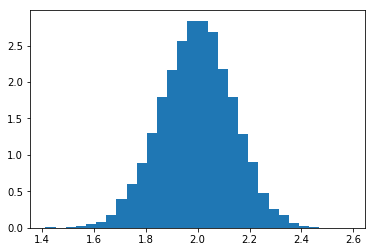

In [98]:
M = 10000
exp_vals = np.zeros((M,))

for i in range(M):
    try:
        samples, weights, weights_normalized = imp_sample_prop(200, scale=3)
        exp_vals[i] = np.sum(samples * weights_normalized)
    except TooLittleSampleCoverage:
        exp_vals[i] = np.nan
        
# Remove NaN values
exp_vals = exp_vals[~np.isnan(exp_vals)]
    
print("Average: {}".format(exp_vals.mean()))
biases = exp_vals - 2
print("Bias: {}".format(biases.mean()))

fig, ax = plt.subplots()
ax.hist(exp_vals, bins=30, normed=True);

g) Solution to what? The bias correction? Isn't that done anyway? The normalized weights sum to one as far as I can tell...

## I.2 Importance sampling in higher dimensions

Consider importance sampling in a $D$-dimensional space. Let the proposal $q(x) = N(x; 0, I_D)$ be the $D$-dimensional normal distribution and the target $\pi(x) = U(x; [-0.5, 0.5]^D)$. Exact evaluation of the target is allowed.

This means 
$$\pi(x) = \frac{1}{(0.5 - (-0.5))^D} \prod_{i = 1}^D 1_{[-0.5, 0.5]}(x_i) = \prod_{i = 1}^D 1_{[-0.5, 0.5]}(x_i)$$

In [99]:
def multivariate_uniform_pdf(x, a=-0.5, b=0.5):
    if np.alltrue(x >= a) and np.alltrue(x <= b):
        return 1
    else:
        return 0
    
def imp_sample(N, D):
    # Sample from the proposal
    samples = stats.multivariate_normal.rvs(np.zeros((D,)), np.identity(D), N)
    # Calculate exact weights
    weights = np.apply_along_axis(multivariate_uniform_pdf, 1, samples) / \
                stats.multivariate_normal.pdf(samples, mean=np.zeros((D,)), 
                                              cov=np.identity(D))
    
    return samples, weights

Create a histogram in two dimensions to see if the code works.

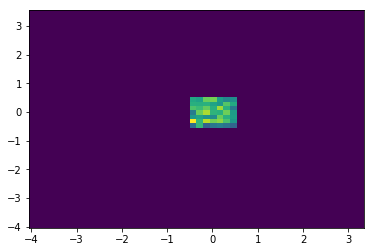

In [100]:
N = 8000
D = 2

fig, ax = plt.subplots()

samples, weights = imp_sample(N, D)
ax.hist2d(samples[:, 0], samples[:, 1], bins=50, weights=weights);

Iterate over the dimension and see how the proportion of non-zero weights develops.

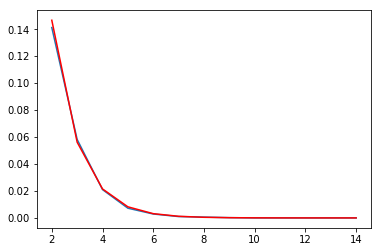

In [101]:
N = 10000

proportion = []
probability = []

for D in range(2, 15):
    samples, weights = imp_sample(N, D)
    proportion.append(len(weights[weights != 0.0]) / len(weights))
    probability.append(
        stats.mvn.mvnun(-0.5*np.ones((D,)), 0.5*np.ones((D,)), 
                        np.zeros((D,)), np.identity(D))[0])
    
proportion = np.array(proportion)
probability = np.array(probability)

fig, ax = plt.subplots()
ax.plot(range(2, 15), proportion);
ax.plot(range(2, 15), probability, 'r');

It seems that the effective amount of weights with non-zero value very rapidly converges to zero. It is so fast that it could be exponential decrease.

Theoretically the weights are
$$\omega(x^i) = \frac{\prod_{j = 1}^D I_{[-0.5, 0.5]}(x^i_j)}{\frac{1}{(2\pi)^{D/2}} \exp\left(-\frac{1}{2} \|x^i\|^2\right)}.$$

With increasing dimension the probability of all components of the sample to be inside of the interval $[-0.5, 0.5]$ get lower and lower. Thus the number of zero samples increases.

The probability for all components of a sample from the $D$-dimensional normal distribution to be between $-0.5$ and $0.5$ is
$$P(-0.5 \leq x \leq 0.5) = P(x \leq 0.5) - P(x < -0.5) = 2 \cdot \Phi_D(0.5) - 1$$.

Here it holds that
$$
\begin{align}
\Phi_D(z) &= \int_{-\infty}^{z_1}\dots\int_{-\infty}^{z_D} \frac{1}{(2\pi)^{D/2}} \exp\left(-\frac{1}{2} \|x\|^2\right)\,\mathrm{d}x = \\
&= \frac{1}{(2\pi)^{D/2}} \int_{-\infty}^{z_1} \exp\left(-\frac{1}{2} x_1^2\right)\,\mathrm{d}x_1\,\dots\,\int_{-\infty}^{z_D} \exp\left(-\frac{1}{2} x_D^2\right)\,\mathrm{d}x_D
\end{align}
$$
and thus
$$\Phi_D(0.5) = \Phi_1(0.5)^D \rightarrow 0\quad\text{for}\quad D \rightarrow \infty$$
since $\Phi_1(0.5) < 1$. This explains why the decrease is exponentially fast.

In [122]:
stats.norm.cdf(0.5)

0.69146246127401312

## I.3 An important numerical aspect

Skip for now...

## I.4 Bootstrap particle filter for the stochastic volatility model

Consider the stochastic volatility model
$$
\begin{align}
x_t\,|\,x_{t - 1} &\sim N(x_t; \phi \cdot x_{t - 1}, \sigma^2) \\
y_t\,|\,x_t &\sim N(y_t; 0, \beta^2 \cdot \exp(x_t))
\end{align}
$$
with parameter vector $\theta = (\phi, \sigma, \beta)$.

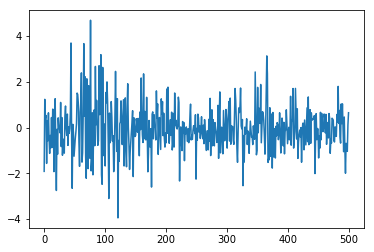

In [2]:
data = pd.read_csv('..\\base_material\\seOMXlogreturns2012to2014.csv', 
                   header=None, names=['logreturn'])
y = data.logreturn.values

fig, ax = plt.subplots()
ax.plot(y)

Assume the parameter vector is given as $\theta = (0.98, 0.16, 0.70)$. 

In [110]:
theta = [0.98, 0.16, 0.70]

def bootstrap_pf(N, y):
    # Save the history
    xs = []
    ws = []
    # Initialisation
    samples = stats.norm.rvs(0, theta[1], N)
    weights = 1 / N * np.ones((N,))
    weights_normalized = weights
    
    # Save weights and samples
    ws.append(weights_normalized)
    xs.append(samples)
    
    # Determine the number of time steps
    T = len(y)
    # Loop through all time steps
    for t in range(T):
        # Resample
        # Randomly choose ancestors
        ancestors = np.random.choice(samples, size=N, 
                                     replace=True, p=weights_normalized)
        
        # Propagate
        samples = stats.norm.rvs(0, 1, N) * theta[1] + theta[0] * ancestors
        # Save the new x
        xs.append(samples)
        
        # Weight
        weights = stats.norm.logpdf(y[t], loc=0,
                                    scale=(theta[2] * np.exp(samples / 2)))
        # Substract maximum
        weights = weights - np.max(weights)
        # Normalize weights to be probabilities
        weights_normalized = np.exp(weights) / np.sum(np.exp(weights))
        # Save the new normalized weights 
        ws.append(weights_normalized)
        
    return np.array(xs), np.array(ws)

Execute the bootstrap particle filter

In [119]:
# np.random.seed(2017)
xs, ws = bootstrap_pf(500, y)

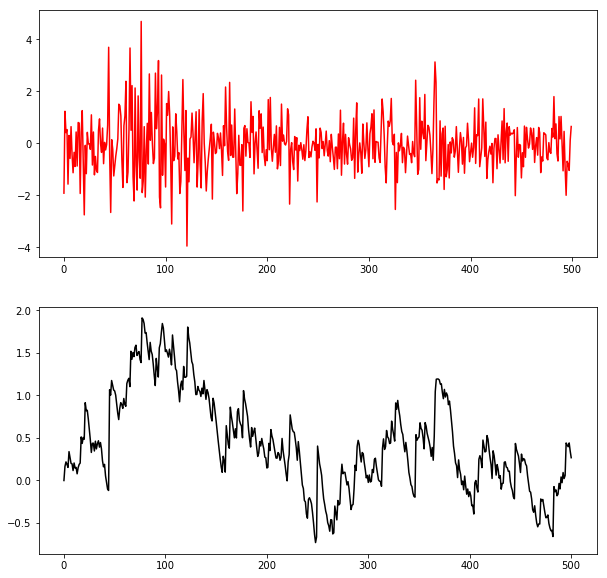

In [121]:
xs_means = np.apply_along_axis(np.sum, 1, ws * xs)
# q2_5 = np.apply_along_axis(partial(np.percentile, q=2.5), 1, xs)
# q97_5 = np.apply_along_axis(partial(np.percentile, q=97.5), 1, xs)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(y, 'r');

# axs[1].fill_between(range(len(xs_means)), q97_5, q2_5, facecolor='grey', alpha=0.4)
axs[1].plot(xs_means, 'k');

I have a very hard time telling whether or not this estimate is reasonable...